In [1]:
import ccxt
import pandas as pd
import numpy as np
import requests
import time
from datetime import datetime as dt ,timedelta
import pandas_ta as ta


### Exchange Setting ################################################################################
ex = ccxt.ftx({'enableRateLimit':True})
ex_b = ccxt.binance({'enableRateLimit':True})
##############################################################################

token = '' ############## Line token





In [1]:
# https://medium.com/codex/build-your-advanced-crypto-alert-system-in-python-part-1-bace6909d3be
def get_data(symbols,timeframe='1h',since=None,limit=100):
    
        data= pd.DataFrame(ex.fetch_ohlcv(symbols,timeframe,since=None,limit=limit)
                         ,columns=['date','open','high','low','close','volume'])
        data['volume'] =(data['volume'].astype('float'))
        data['date']=data['date'].apply(ex.iso8601)
        data['date']=pd.to_datetime(data['date'])
        data.set_index('date',inplace=True)
        data.index = data.index.tz_localize(None) # Clean format

        return data
    
    
    

def vwap_fun(df, n=3):
    v = df['volume'].rolling(n).mean()
    tp = (df['low'].rolling(n).min() + df['close'].rolling(n).mean() + df['high'].rolling(n).max()).div(3).values
    df['vwap']=(tp*v).cumsum()/ v.cumsum()
    # return df.assign(vwap=(tp*v).cumsum()/v.cumsum())
    return df['vwap']


def volume_fun(df, n=24, deviations=2):
    df['vol_up_band'] = df['volume'].rolling(n).mean() +df['volume'].rolling(n).std()*deviations
    return df['vol_up_band']


def get_trade(symbols,start_time:dt.timestamp,end_time:dt.timestamp):

    ids = set()
    limit = 100
    results = []
    # print(dt.fromtimestamp(start_time),':::',dt.fromtimestamp(end_time))
    while True:
                response = requests.get(f'https://ftx.com/api/markets/{symbol}/trades', {
                'end_time': end_time,
                'start_time': start_time,
            }).json()
                trades = [r for r in response['result'] if r['id'] not in ids]
                results.extend(trades)
                ids = [r['id'] for r in trades]
                if len(response) == 0: # if cannot fetch trades data
                    break
                end_time = dt.fromisoformat(max([t['time'] for t in response['result']])).timestamp()
                if len(response) < limit:
                    break
    trades_df = pd.DataFrame(results)
    trades_df['trade_sign'] = trades_df['side'].apply(lambda x: 1 if x=='buy' else -1)
    trades_df['dollar_flow'] = trades_df['price']*trades_df['size']*trades_df['trade_sign']
    return trades_df

def get_all_trade(symbol):
    df = pd.DataFrame()
    end_dt =dt.now() # datetime type
    end_time = int(end_dt.timestamp()) # 

    start_time =int(( end_dt -timedelta(hours=1)).timestamp())

    for i in range(24): #  delta 1 weeks 
        trade_df = get_trade(symbol,start_time,end_time)
        df = df.append(trade_df)
        end_time = start_time
        start_time = int(( dt.fromtimestamp(end_time) - timedelta(hours=1)).timestamp())
    df['time'] = pd.to_datetime(df['time']) # Convert Values to datetime
    df = df.set_index('time') # Set Index 
    df = df.groupby(pd.Grouper(freq='1h'))['dollar_flow'].sum().to_frame() # aggerate timestamp
    df['symbol'] = symbol
    df.index.name ='date'
    df.index = df.index.tz_localize(None) # Clean format
    return df

NameError: name 'dt' is not defined

In [3]:
def send_line(message,token):
        url = 'https://notify-api.line.me/api/notify'
        header = {'content-type':'application/x-www-form-urlencoded','Authorization':'Bearer '+token}   
        command = {'message':message}
        return requests.post(url, headers=header, data = command )
    
def send_image(message, file_name,token):
        url = 'https://notify-api.line.me/api/notify'
        session = requests.Session()
        data =  ({'message': str(message)})
        file_img = {'imageFile': open(f'{file_name}', 'rb')}
        LINE_HEADERS = {'Authorization':'Bearer '+token}
        session_post = session.post(url, headers=LINE_HEADERS, files=file_img, data=data)
        return (session_post.text)
    

# img= f'images/{file_name}'
# send_line('Test_bot',token)

In [13]:
def diff_alert(df,trigger=1.0):
    prev_price = df['close'].iloc[-2]
    last_price = df['close'].iloc[-1]
    last_rsi =df['rsi'].iloc[-1] 
    diff=  ((last_price/prev_price-1)*100) # 
    cond1= abs(diff) >= trigger
    cond2 = last_rsi>=50
    cond = cond1 & cond2
    return {'condition':cond,'last_price':last_price,'diff':diff ,'rsi':last_rsi}





def bot_alert(symbol,trigger,token):
    df =get_data(symbol)
    df['rsi'] =df.ta.rsi(14) 
    
    cond = diff_alert(df,trigger)
    last_price = cond['last_price']
    last_rsi = cond['rsi']
    last_diff = cond['diff']
    if  cond['condition'] :

        msg= f'{symbol} : Price {last_price} :Change {last_diff:.2f} % , {last_rsi:.2f}'
        send_line(msg,token)
    else:

        print(f' {dt.now()}: Not Alert {last_price} : Change {last_diff} %  : RSI {last_rsi}', )

In [14]:
symbols ='BTC-PERP'
df =get_data(symbols)
df['rsi'] =df.ta.rsi(14) 
df

,open,high,low,close,volume,rsi
date,,,,,,
2022-03-16 10:00:00,40534.0,40696.0,40189.0,40338.0,1.449461e+08,NaN
2022-03-16 11:00:00,40338.0,40698.0,40257.0,40537.0,1.357723e+08,NaN
2022-03-16 12:00:00,40537.0,40689.0,40358.0,40385.0,1.016671e+08,NaN
2022-03-16 13:00:00,40385.0,40664.0,40273.0,40658.0,1.393599e+08,NaN
2022-03-16 14:00:00,40658.0,41222.0,40384.0,40846.0,4.320975e+08,NaN
...,...,...,...,...,...,...
2022-03-20 09:00:00,41892.0,41906.0,41602.0,41792.0,9.659136e+07,46.993496
2022-03-20 10:00:00,41792.0,41871.0,41680.0,41795.0,4.282855e+07,47.125525
2022-03-20 11:00:00,41795.0,41850.0,41613.0,41618.0,2.988932e+07,40.686393


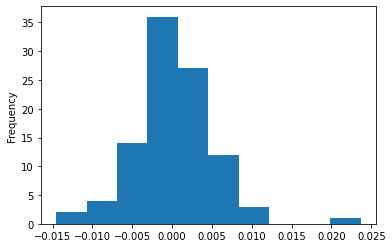

In [11]:
df['ret'] =np.log(df.close/df.close.shift(1))
df.ret.plot.hist()

In [15]:
import schedule
from IPython.display import clear_output


symbols= 'BTC-PERP'
# Alert bot every 5 Minutes
# schedule.every(5).minutes.do(bot_alert,symbol=symbols,trigger=1.0) # 
schedule.every(5).seconds.do(bot_alert,symbol=symbols,trigger=0.01,token=token)
while True:
    schedule.run_pending()
#     clear_output(True) # Jupyter notebook 
    time.sleep(1)


KeyboardInterrupt: 

In [14]:
symbol ='ETH-PERP'



df =get_data(symbol)
df['rsi'] =df.ta.rsi(14) 
df['vwap']=vwap_fun(df,5)
df['vol_up_band'] =volume_fun(df,20,2)

trades_df= get_all_trade(symbol)
final_df = df.merge(trades_df, left_index=True, right_index=True, how='left')
final_df =final_df.dropna()
final_df['vwap_chg'] = (final_df['vwap']/final_df['close']).diff() # ((final_df['vwap']/final_df['close']) -1).diff()
final_df['ret'] = final_df['close'].pct_change() # if 
final_df

,open,high,low,close,volume,rsi,vwap,vol_up_band,dollar_flow,symbol,vwap_chg,ret
date,,,,,,,,,,,,
2022-03-19 12:00:00,2948.6,2973.8,2944.2,2973.5,3.814595e+07,68.237025,2803.943375,1.237482e+08,5.548793e+05,ETH-PERP,NaN,NaN
2022-03-19 13:00:00,2973.5,2979.3,2946.9,2950.7,6.058657e+07,59.522421,2805.043583,1.021617e+08,-5.480142e+06,ETH-PERP,0.007659,-0.007668
2022-03-19 14:00:00,2950.5,2967.1,2940.7,2964.6,2.975703e+07,62.653820,2805.993730,9.999588e+07,-4.686900e+05,ETH-PERP,-0.004137,0.004711
2022-03-19 15:00:00,2964.6,2980.0,2955.0,2969.5,5.280702e+07,63.719348,2807.079505,8.205565e+07,-1.194704e+06,ETH-PERP,-0.001196,0.001653
2022-03-19 16:00:00,2969.5,2988.6,2958.1,2976.3,5.902144e+07,65.203086,2808.397053,6.988045e+07,3.999889e+06,ETH-PERP,-0.001717,0.002290
2022-03-19 17:00:00,2976.3,2979.0,2951.1,2959.1,4.437020e+07,58.667511,2809.718004,7.032464e+07,-4.184016e+06,ETH-PERP,0.005931,-0.005779
2022-03-19 18:00:00,2959.1,2960.5,2946.5,2958.2,3.558286e+07,58.338003,2810.889830,6.930179e+07,1.159464e+06,ETH-PERP,0.000685,-0.000304
2022-03-19 19:00:00,2958.2,2959.2,2948.7,2951.7,1.913004e+07,55.896224,2811.996781,6.969224e+07,-1.196200e+06,ETH-PERP,0.002467,-0.002197
2022-03-19 20:00:00,2951.7,2969.0,2942.7,2955.1,3.456444e+07,56.912145,2812.979850,6.429481e+07,4.804850e+06,ETH-PERP,-0.000763,0.001152


In [67]:
last_row = final_df.iloc[-1:]
alert_cond = ((last_row['ret']>=0.0001) & (last_row['rsi']>=50.0) & (last_row['vwap_chg']>=0.0)  )[0] #> boolean
if alert_cond :
    print('Send Line')
else:
    print(last_row,alert_cond)

                       open    high     low   close        volume  \
date                                                                
2022-03-20 10:00:00  2922.3  2927.3  2911.1  2918.9  1.925243e+07   

                            vwap   vol_up_band        rsi  dollar_flow  \
date                                                                     
2022-03-20 10:00:00  2822.004218  9.456373e+07  44.342885  573913.2289   

                       symbol  vwap_chg       ret  
date                                               
2022-03-20 10:00:00  ETH-PERP  0.001252 -0.001163   False


,open,high,low,close,volume,vwap,vol_up_band,rsi,dollar_flow,symbol,vwap_chg,ret
date,,,,,,,,,,,,
